In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [87]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [73]:
X_train = pd.read_csv("../clean_data/X_train.csv", index_col = 0)
X_val = pd.read_csv("../clean_data/X_val.csv", index_col = 0)

y_train = pd.read_csv("../clean_data/y_train.csv", index_col = 0, header=None)
y_val = pd.read_csv("../clean_data/y_val.csv", index_col = 0, header=None)

X_test = pd.read_csv("../clean_data/test.csv", index_col = 0)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

C:\Users\axel\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


((1072203, 21), (1072203, 1), (459516, 21), (459516, 1))

# Model 1 - logistic regression

We'll used logistic regression as a simple benchmark

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

c, r = y_train.values.shape
labels = y_train.values.reshape(c,)

#pipeline = make_pipeline(StandardScaler(), 
#                         LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True,
#                                            penalty='l2', tol=0.0001))


pipeline = make_pipeline(StandardScaler(), 
                         LogisticRegression(class_weight="balanced"))
params = {'logisticregression__C': [0.01, 0.1, 1, 10, 100] }


grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='f1', verbose=10)

grid.fit(X_train, labels)


print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] logisticregression__C=0.01 ......................................
[CV] ....... logisticregression__C=0.01, score=0.020782, total=  20.8s
[CV] logisticregression__C=0.01 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.1s remaining:    0.0s


[CV] ....... logisticregression__C=0.01, score=0.021425, total=  34.6s
[CV] logisticregression__C=0.01 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.1s remaining:    0.0s


[CV] ....... logisticregression__C=0.01, score=0.021397, total=  16.6s
[CV] logisticregression__C=0.1 .......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV] ........ logisticregression__C=0.1, score=0.021401, total=  56.7s
[CV] logisticregression__C=0.1 .......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


[CV] ........ logisticregression__C=0.1, score=0.021614, total=  53.5s
[CV] logisticregression__C=0.1 .......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s


[CV] ........ logisticregression__C=0.1, score=0.022035, total=  31.6s
[CV] logisticregression__C=1 .........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.6min remaining:    0.0s


[CV] .......... logisticregression__C=1, score=0.022557, total=  36.0s
[CV] logisticregression__C=1 .........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.2min remaining:    0.0s


[CV] .......... logisticregression__C=1, score=0.022038, total=  50.6s
[CV] logisticregression__C=1 .........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.1min remaining:    0.0s


[CV] .......... logisticregression__C=1, score=0.023178, total= 1.0min
[CV] logisticregression__C=10 ........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.1min remaining:    0.0s


[CV] ......... logisticregression__C=10, score=0.022910, total= 1.1min
[CV] logisticregression__C=10 ........................................
[CV] ......... logisticregression__C=10, score=0.022139, total=  49.9s
[CV] logisticregression__C=10 ........................................
[CV] ......... logisticregression__C=10, score=0.022729, total= 1.1min
[CV] logisticregression__C=100 .......................................
[CV] ........ logisticregression__C=100, score=0.022964, total= 1.6min
[CV] logisticregression__C=100 .......................................
[CV] ........ logisticregression__C=100, score=0.022214, total=  54.7s
[CV] logisticregression__C=100 .......................................
[CV] ........ logisticregression__C=100, score=0.023532, total= 1.0min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 12.7min finished


Best params:
{'logisticregression__C': 100}

Best cross-validation score: 0.02


Logistic models outputs a probability for each classes. We can optimize the threshold using an elbow curve.

C:\Users\axel\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


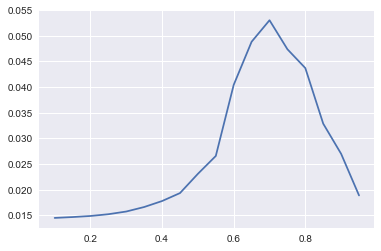

In [78]:
predictions = grid.predict_proba(X_val)

thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []

for threshold in thresholds:
    pred_thresholds = predictions[:, 1] > threshold
    f1_scores.append(f1_score(y_val, pred_thresholds))

plt.plot(thresholds, f1_scores)

The best threshold is around 0.65. We'll use that to predict the test set.

In [82]:
best_prediction = (predictions[:, 1] > 0.65)

In [86]:
confusion = pd.DataFrame(confusion_matrix(y_val, best_prediction), 
                         index=['is_not_back_order', 'is_back_order'],
                         columns=['predicted_not_back_order', 'predicted_back_order'])
print(confusion)

                   predicted_not_back_order  predicted_back_order
is_not_back_order                    446572                  9825
is_back_order                          2795                   324


In [88]:
print(classification_report(y_val, best_prediction))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99    456397
          1       0.03      0.10      0.05      3119

avg / total       0.99      0.97      0.98    459516



Output model

In [99]:
test_pred = grid.predict_proba(X_test)
test_pred_thresh = (test_pred[:, 1] > 0.65).astype(int)

df = pd.DataFrame(test_pred_thresh)

df.to_csv("../predictions/axel_logistic.csv")
    

In [98]:
df = pd.DataFrame(test_pred_thresh)
df.shape

(5000, 1)

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

IndexError: too many indices for array

In [ ]:


print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
param_grid = [
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))